# Exercise 1

Suppose our current system uses an $\epsilon$-greedy policy for model selection (mostly choosing GPT-5, occasionally a cheaper model). Define a logging schema for each interaction: what context, action, and probability information must we log to enable unbiased OPE of a new routing policy? Outline the data structure clearly.

## Solution

To evaluate a routing policy that optimizes for **Profit** (Revenue minus Model Cost), our logging schema and OPE must treat financial metrics as the primary reward signal.

### The Profit-Centric Logging Schema

To enable unbiased OPE, we must log not only the final profit but also the **components** (Revenue and Cost). This allows us to re-calculate OPE if model prices change in the future.

| Field | Type | Description |
| :--- | :--- | :--- |
| `request_id` | UUID | Unique identifier for the interaction. |
| **`context` ($x$)** | JSON/Vector | Features used (user tier, prompt complexity, historical LTV). |
| **`action_id` ($a$)** | Integer/ID | The model selected from the catalog (e.g., `1` for GPT-5). |
| **`propensity` ($\mu$)** | Float | $P(a \mid x)$—the exact probability the logger chose this model. |
| **`revenue`** | Float | Value generated (e.g., successful conversion, subscription proxy). |
| **`model_cost`** | Float | The actual token/compute cost of the chosen model. |
| **`reward` ($r$)** | Float | **The Net Profit:** `revenue - model_cost`. |
| `catalog_snapshot` | List[Int] | IDs of all models available in the catalog at runtime. |

---

### Data Structure (JSON Example)

```json
{
  "request_id": "9a1b...",
  "context": {
    "user_segment": "enterprise",
    "prompt_type": "legal_summary",
    "expected_tokens": 1200
  },
  "decision": {
    "action_id": 1, 
    "propensity": 0.95,
    "catalog_snapshot": [1, 2, 3] 
  },
  "financials": {
    "revenue": 5.00,        // e.g., value of a sold goods
    "model_cost": 0.04,     // token cost for GPT-5
    "profit_reward": 4.96   // Net reward (r)
  }
}
```

---



#### 3. Why log Revenue and Cost separately?
If a model provider (like OpenAI) drops their prices tomorrow, the `profit_reward` logs become outdated. By logging `revenue` and `model_cost` separately, the logs can be **re-processed** with updated costs and used to run a "What If" OPE: *"What would our profit look like under the new pricing if we switched to this cheaper model?"*



# Exercise 2

Implement IPS and Doubly Robust estimators for off-policy policy value. Use a synthetic logged dataset (e.g., generated by a known policy on a multi-armed bandit) and a candidate target policy. Compare their estimates to the ground-truth value. Then implement the SWITCH estimator: for each instance, decide to use IPS or a model prediction based on whether the importance weight is below a threshold. Show that SWITCH yields lower Mean Squared Error than plain IPS when the target policy is significantly different from the logging policy.

## Solution

We simulate a **contextual multi-armed bandit** with a known reward model `q(x,a)` (Bernoulli with logistic mean), then:

- Generate a logged dataset by sampling actions from a known **logging policy** `μ(a|x)`.
- Define a different **target policy** `π(a|x)` and compute the ground-truth value `V(π)` by Monte Carlo using the known `q(x,a)`.
- Estimate `V(π)` from logged data using:
  - **IPS**: `mean(w * r)` where `w = π(a|x) / μ(a|x)`.
  - **DR**: `mean( sum_a π(a|x) q̂(x,a) + w * (r - q̂(x,a_logged)) )`.
  - **SWITCH-DR**: like DR, but only uses the IPS correction term when `w <= τ` (otherwise it falls back to the model term).

For the reward model `q̂(x,a)` used by DR/SWITCH-DR, we fit **one L2-regularized logistic regression per action** using scikit-learn's `LogisticRegression`.

Ground-truth V(pi) ≈ 0.5766
IPS:       mean=0.5724, MSE=0.003410
DR:        mean=0.5756, MSE=0.001011
SWITCH-DR: mean=0.5762, MSE=0.000440  (best tau=1)
Importance weight quantiles (last trial): [0.0000e+00 5.0000e-03 2.4195e+01 2.4901e+01]


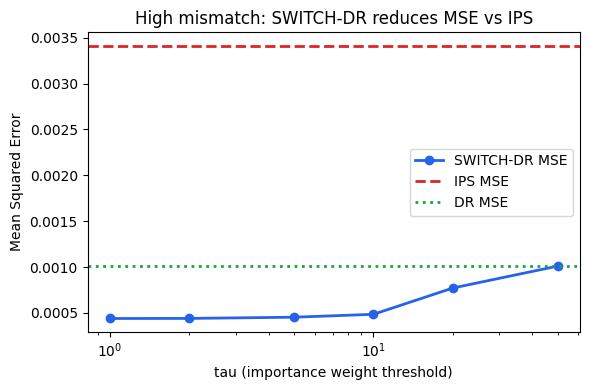

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.utils.extmath import softmax as sk_softmax
except ImportError as e:
    raise ImportError("This exercise requires scikit-learn. Install with: pip install scikit-learn") from e


# ----------------------------
# Helpers
# ----------------------------


def policy_probs(X: np.ndarray, B: np.ndarray, temp: float = 1.0, eps: float = 0.0) -> np.ndarray:
    """Calculates action probabilities: softmax(scores/temp) + epsilon-exploration."""
    # Compute logits scaled by temperature (higher temp = more uniform)
    logits = (X @ B) / temp
    p = sk_softmax(logits)
    # Mix in uniform exploration if eps > 0
    if eps > 0:
        K = p.shape[1]
        p = (1.0 - eps) * p + eps / K
    return p


def sample_categorical(rng: np.random.Generator, probs: np.ndarray) -> np.ndarray:
    """Randomly picks one action per row based on probabilities."""
    # Build cumulative distribution function along action axis
    cdf = np.cumsum(probs, axis=1)
    # Draw uniform random values for each sample
    u = rng.random((probs.shape[0], 1))
    # Count how many CDF thresholds we exceed -> gives us the chosen action index
    return (u > cdf).sum(axis=1)


def expit(z: np.ndarray) -> np.ndarray:
    """Numerically-stable logistic function (a.k.a. sigmoid)."""
    z = np.clip(z, -35, 35)
    return 1.0 / (1.0 + np.exp(-z))


def add_intercept(x: np.ndarray) -> np.ndarray:
    """Prepends a column of ones to features for the bias term."""
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)


# ----------------------------
# Reward model (Direct Method): per-action ridge logistic regression
# ----------------------------

def fit_reward_model(
    X: np.ndarray,
    a: np.ndarray,
    r: np.ndarray,
    K: int,
    iters: int = 25,
) -> np.ndarray:
    """Fit a per-action reward model `q̂(x,a)`.

    Fit K independent `sklearn.linear_model.LogisticRegression` models
    (one per actionarm), with `fit_intercept=False` because `X` already includes an
    intercept column.

    Args:
        X: Feature matrix of shape (n, d), where n is the number of samples
            and d is the number of features. Should include an intercept column.
        a: Action indices of shape (n,), where each entry is in {0, 1, ..., K-1}.
        r: Reward vector of shape (n,), containing binary rewards (0 or 1).
        K: Number of actions/arms in the bandit problem.
        iters: Maximum number of iterations for the LBFGS solver.
            Actual max_iter is max(200, iters).

    Returns:
        W_hat: Weight matrix of shape (d, K) such that the predicted reward
            probability for action a is `q̂(x, a) = expit(X @ W_hat[:, a])`.
    """
    d = X.shape[1]
    W_hat = np.zeros((d, K))

    for arm in range(K):
        idx = a == arm
        if idx.sum() == 0:
            continue

        y = r[idx].astype(int)

        # Tiny guard: if an arm has only one class, sklearn can't fit.
        if np.unique(y).size < 2:
            p = float(np.clip(y.mean(), 1e-6, 1.0 - 1e-6))
            W_hat[0, arm] = np.log(p / (1.0 - p))  # intercept-only constant model
            continue

        model = LogisticRegression(
            solver="lbfgs",
            fit_intercept=False,
            max_iter=max(200, int(iters)),
        )
        model.fit(X[idx], y)
        W_hat[:, arm] = model.coef_.ravel()

    return W_hat


# ----------------------------
# OPE estimators
# ----------------------------

def ope_estimates(
    a: np.ndarray,
    r: np.ndarray,
    mu_logged: np.ndarray,
    pi_chosen: np.ndarray,
    pi_full: np.ndarray,
    qhat_full: np.ndarray,
    taus: np.ndarray,
) -> tuple:
    """Compute IPS, DR, and gated SWITCH-DR estimators.

    Args:
        a: Chosen actions, shape (n,).
        r: Observed rewards, shape (n,).
        mu_logged: Logging policy probabilities for chosen actions, shape (n,).
        pi_chosen: Target policy probabilities for chosen actions, shape (n,).
        pi_full: Target policy probabilities for all actions, shape (n, K).
        qhat_full: Estimated reward model for all actions, shape (n, K).
        taus: SWITCH thresholds for importance weight clipping, shape (T,).

    Returns:
        ips: Inverse Propensity Scoring estimate.
        dr: Doubly Robust estimate.
        swdr: SWITCH-DR estimates for each threshold, shape (T,).
        w: Importance weights, shape (n,).
    """
    n = r.shape[0]
    w = pi_chosen / mu_logged  # importance weights

    qhat_ai = qhat_full[np.arange(n), a]  # q-hat for chosen action
    dm_per_sample = (pi_full * qhat_full).sum(axis=1)  # direct method term

    ips = np.mean(w * r)
    dr = np.mean(dm_per_sample + w * (r - qhat_ai))

    swdr = np.empty_like(taus, dtype=float)
    for j, tau in enumerate(taus):
        use = w <= tau
        swdr[j] = np.mean(dm_per_sample + use * w * (r - qhat_ai))

    return ips, dr, swdr, w


# ----------------------------
# Experiment: high mismatch -> SWITCH-DR lower MSE than IPS
# ----------------------------

rng = np.random.default_rng(0)

# Bandit dimensions
K = 5
x_dim = 5

# Logged dataset size + Monte Carlo trials
n = 3000
R = 200

# SWITCH thresholds (importance weight cutoff)
taus = np.array([1, 2, 5, 10, 20, 50], dtype=float)

# True environment: Bernoulli reward with logistic mean
Theta_true = rng.normal(scale=1.0, size=(x_dim + 1, K))

# Logging / target policies: softmax over linear scores
Beta_mu = rng.normal(scale=1.0, size=(x_dim + 1, K))

# Mismatch knob
mismatch_scale = 2.0
Beta_pi = -mismatch_scale * Beta_mu + 0.1 * rng.normal(size=(x_dim + 1, K))

temp_mu = 1.0
temp_pi = 0.2 # pi is sharper with lower temperature

# Ensure mu(a|x) > 0 for all actions (stabilizes importance weights)
eps_mu = 0.2

# Ground-truth value V(pi) by Monte Carlo (q is known)
n_eval = 100_000
X_eval = np.concatenate([np.ones((n_eval, 1)), rng.normal(size=(n_eval, x_dim))], axis=1) #context 
q_eval = expit(X_eval @ Theta_true) #true environment reward function
pi_eval = policy_probs(X_eval, Beta_pi, temp=temp_pi, eps=0.0) #target policy
V_true = float(np.mean(np.sum(pi_eval * q_eval, axis=1))) #true expected value of target policy

ips_est = np.zeros(R)
dr_est = np.zeros(R)
swdr_est = np.zeros((len(taus), R))

for t in range(R):
    X = np.concatenate([np.ones((n, 1)), rng.normal(size=(n, x_dim))], axis=1)

    mu_full = policy_probs(X, Beta_mu, temp=temp_mu, eps=eps_mu) #logging policy
    a = sample_categorical(rng, mu_full) #action sampled from logging policy
    mu_logged = mu_full[np.arange(n), a] #logging policy probability for the chosen action

    pi_full = policy_probs(X, Beta_pi, temp=temp_pi, eps=0.0) #target policy
    pi_chosen = pi_full[np.arange(n), a] #target policy probability for the chosen action

    q_true_full = expit(X @ Theta_true)  
    # True environment expected reward for each context–action pair

    q_true_chosen = q_true_full[np.arange(n), a]  
    # True expected reward for the logged action

    r = (rng.random(n) < q_true_chosen).astype(float)  
    # Observed reward sampled from the environment

    # Direct method reward model qhat(x,a)
    # Fit a logistic regression model to estimate expected reward q(x,a)
    # This learns weights W_hat from observed (context, action, reward) tuples
    W_hat = fit_reward_model(X, a, r, K=K, iters=25)
    
    # Predict reward probabilities for all context-action pairs using the fitted model
    # qhat_full[i, k] = estimated P(reward=1 | context x_i, action k)
    qhat_full = expit(X @ W_hat)

    ips, dr, swdr, w = ope_estimates(a, r, mu_logged, pi_chosen, pi_full, qhat_full, taus)

    ips_est[t] = ips
    dr_est[t] = dr
    swdr_est[:, t] = swdr #matrix because each row has different tau

ips_mse = float(np.mean((ips_est - V_true) ** 2))
dr_mse = float(np.mean((dr_est - V_true) ** 2))
swdr_mse = np.mean((swdr_est - V_true) ** 2, axis=1)
best_i = int(np.argmin(swdr_mse))

print(f"Ground-truth V(pi) ≈ {V_true:.4f}")
print(f"IPS:       mean={ips_est.mean():.4f}, MSE={ips_mse:.6f}")
print(f"DR:        mean={dr_est.mean():.4f}, MSE={dr_mse:.6f}")
print(
    f"SWITCH-DR: mean={swdr_est[best_i].mean():.4f}, MSE={swdr_mse[best_i]:.6f}  (best tau={taus[best_i]:g})"
)
print("Importance weight quantiles (last trial):", np.quantile(w, [0.5, 0.9, 0.99, 0.999]).round(3))

plt.figure(figsize=(6, 4))

# SWITCH-DR: solid blue line with markers
plt.plot(taus, swdr_mse, marker="o", color="#2563eb", linewidth=2, label="SWITCH-DR MSE")

# IPS: dashed red line
plt.axhline(ips_mse, linestyle="--", color="#dc2626", linewidth=2, label="IPS MSE")

# DR: dotted green line
plt.axhline(dr_mse, linestyle=":", color="#16a34a", linewidth=2, label="DR MSE")

plt.xscale("log")
plt.xlabel("tau (importance weight threshold)")
plt.ylabel("Mean Squared Error")
plt.title("High mismatch: SWITCH-DR reduces MSE vs IPS")
plt.legend()
plt.tight_layout()
plt.show()



# Exercise 3

Theory: Explain why off-policy evaluation is fundamentally hard when the new policy differs a lot from the logging policy (the “coverage” problem). What is propensity overfitting and how do techniques like weight clipping or SWITCH address it? Discuss how OPE at Sqwish helps us be safe - e.g. detecting if a proposed change (like more aggressive exploration) could tank reward for a subset of users before we deploy it live.

## Solution

### 1. The Coverage Problem (The "Hard" Part)
OPE is counterfactual reasoning: "What if we had acted differently?" We use Inverse Probability Weighting (IPS) to adjust for the difference between the new policy ($\pi$) and the old one ($\mu$):
$$w_i = \frac{\pi(a_i \mid x_i)}{\mu(a_i \mid x_i)}$$
**The Problem:** If the old policy rarely explored an action ($\mu \approx 0$) that the new policy wants to take, the weight $w_i$ explodes toward infinity. This causes **variance explosion**: a single random event in the logs can single-handedly dictate the entire evaluation. 
If a region of the action space was not explored, it cannot be evaluated without making assumptions.

### 2. Propensity Overfitting
In practice, we often estimate the logging probabilities ($\hat{\mu}$). 
**Propensity overfitting** happens when $\hat{\mu}$ becomes too confident or "memorizes" the logs. 
If $\hat{\mu}$ predicts an action was nearly impossible in a certain context, the resulting weight ($1/\hat{\mu}$) becomes massive. This makes the OPE estimate extremely sensitive to noise and training artifacts rather than true signal.

### 3. Stabilizing with SWITCH
To make estimates actionable, we trade a small amount of **bias** for significantly lower **variance** using the **SWITCH** estimator:
*   **High Coverage ($w_i \le \tau$):** Use the data-driven **IPS estimate** (reliable data exists).
*   **Low Coverage ($w_i > \tau$):** "Switch" to a **Reward Model** (Direct Method) to predict the outcome.
*   **Result:** We use actual data where it is dense and rely on model-based extrapolation only where the data is too thin to trust.

SWITCH tames aggressive exploration by capping variance, it replaces noisy, high-weight importance samples with stable reward-model predictions whenever data is too thin to trust. 


### 4. Sqwish Connection
At Sqwish, OPE could act as a virtual stress test, allowing us to detect if a globally positive policy actually "tanks" rewards globally or for specific user segments  before a single live interaction occurs. 